In [1]:
# =============================================================================
# 0. IMPORTS
# =============================================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

np.random.seed(42)

In [2]:
# =============================================================================
# 1. DATA & PCA(50)
# =============================================================================
def load_flat_mnist():
    """Load MNIST data and flatten images to vectors"""
    (Xtr, ytr), (Xte, yte) = mnist.load_data()
    X = np.vstack((Xtr, Xte)).astype("float32").reshape(-1, 784) / 255.0
    y = np.hstack((ytr, yte))
    return X, y

def pca80(Xtr, Xte):
    """Apply PCA with 80 components for dimensionality reduction"""
    pca = PCA(n_components=80, svd_solver="randomized", random_state=42)
    return pca.fit_transform(Xtr), pca.transform(Xte)

# Purpose

Running K-means in the raw 784-dimensional pixel space of MNIST is slow, and the curse of dimensionality makes clusters less separable. PCA reduces the dimension to 80 while retaining about 90 % of the total variance, discarding noise, speeding up computation, and giving cleaner cluster separation.

* Runtime shrinks by roughly one order of magnitude.
* Noise dimensions are removed, so over-fitting risk drops.
* PCA is linear; it may miss curved manifolds.

---
---

To improve model performance and reduce computational cost, I experimented with several different numbers of PCA components. Based on my evaluations, using 80 components provided the best classification results. Furthermore, variance analysis revealed that 80 principal components retained over 90% of the total variance in the dataset. This ensured minimal information loss while significantly reducing the dimensionality. Therefore, I selected 80 components for PCA to maintain a balance between high accuracy and computational efficiency.

In [3]:
# =============================================================================
# 2. CONTINGENCY + GREEDY MAPPING
# =============================================================================
def contingency_table(y_true, clusters):
    """Create contingency table between true labels and clusters"""
    return confusion_matrix(y_true, clusters, labels=range(10))

def print_contingency(tbl):
    """Print contingency table in a readable format"""
    df = pd.DataFrame(tbl,
                      index=[f"L{i}" for i in range(10)],
                      columns=[f"C{j}" for j in range(10)])
    print("\nContingency Table:")
    print(df)

def greedy_mapping(tbl):
    """
    Implement greedy mapping of clusters to labels as described in assignment.
    For each iteration, find maximum value in table and assign that cluster to the label.
    """
    mp, used_r, used_c = {}, set(), set()
    tbl_copy = tbl.copy()  # Work with a copy to avoid modifying original

    for _ in range(10):
        i, j = divmod(tbl_copy.argmax(), 10)
        while i in used_r or j in used_c:
            tbl_copy[i, j] = -1                # mask used cell
            i, j = divmod(tbl_copy.argmax(), 10)
        mp[j] = i                              # cluster j → label i
        used_r.add(i); used_c.add(j)
        tbl_copy[i, :] = -1; tbl_copy[:, j] = -1  # block row & col

    return dict(sorted(mp.items()))

def relabel(clusters, mp):
    """Apply mapping to convert cluster IDs to predicted labels"""
    return np.vectorize(mp.get)(clusters)

# Purpose

K-means is unsupervised, so to evaluate it with supervised metrics such as accuracy we must align each cluster with the correct digit label. The assignment prescribes a “greedy” algorithm that walks through the 10 x 10 contingency matrix, picking the largest cells one by one to build a unique cluster-to-label mapping.

  * Extremely simple and runs in constant time for a 10 x 10 table.
  * Requires no extra libraries; shorter code than the Hungarian algorithm.
  * The printed matrix makes qualitative error analysis straightforward.
  * Greedy choice is not guaranteed to be globally optimal; can be ~1 % worse than Hungarian.
  * Requires no extra libraries; shorter code than the Hungarian algorithm.
  * Provides no probabilistic handling for clusters that cover multiple digits.

---
---

In this project, since K-Means is an unsupervised algorithm, the resulting clusters must be aligned with ground-truth labels to evaluate classification metrics like accuracy. The implemented greedy mapping strategy is simple and efficient: at each step, it picks the maximum cell in the contingency table and assigns that cluster to the corresponding label. It runs in constant time for a 10x10 matrix and requires no external libraries. However, this method does not guarantee a globally optimal solution, and may lead to suboptimal assignments when clusters overlap multiple digits. It can result in about 1% less accuracy compared to more optimal methods.

A well-known alternative is the Hungarian Algorithm (a.k.a. Kuhn-Munkres algorithm), which finds the globally optimal one-to-one assignment that minimizes total mismatch. This can be implemented easily using scipy.optimize.linear_sum_assignment. While the Hungarian method has a higher time complexity (O(n³)), for a 10x10 matrix the performance difference is negligible, and it yields slightly better and theoretically correct results.


In [4]:
# =============================================================================
# 3. CLUSTERING VARIANTS - Four different methods
# =============================================================================
def kmeans_euclid(X, k=10):
    """K-means with Euclidean distance"""
    km = KMeans(k, init="k-means++", n_init=10, random_state=42)
    lab = km.fit_predict(X)
    return lab, km.cluster_centers_

def kmeans_cosine(X, k=10):
    """K-means with cosine distance (using normalized vectors)"""
    Xn = normalize(X)
    km = KMeans(k, init="k-means++", n_init=10, random_state=42)
    lab = km.fit_predict(Xn)
    cents = normalize(km.cluster_centers_)
    return lab, cents, Xn

def kmeans_manhattan(X, k=10, max_iter=50):
    """
    K-means with Manhattan distance (L1 norm)
    Implementation using scikit-learn KMeans initialization and manual updates
    with Manhattan distance and mean for centroids
    """
    # Initialize with k-means++
    km_init = KMeans(k, init="k-means++", n_init=1, max_iter=1, random_state=42)
    km_init.fit(X)
    cent = km_init.cluster_centers_.copy()

    prev_lab = None

    for _ in range(max_iter):
        # Assign points to nearest centroid using Manhattan distance
        dist = cdist(X, cent, metric="cityblock")  # cityblock is L1/Manhattan
        lab = dist.argmin(axis=1)

        # Check for convergence
        if prev_lab is not None and np.array_equal(lab, prev_lab):
            break

        prev_lab = lab.copy()

        # Update centroids - using MEAN (for K-means)
        for c in range(k):
            if (lab == c).any():
                cent[c] = X[lab == c].mean(axis=0)

    return lab, cent

def kmedians_manhattan(X, k=10, max_iter=50):
    """
    K-medians with Manhattan distance (L1 norm)
    Implementation using scikit-learn KMeans initialization and manual updates
    with Manhattan distance and median for centroids
    """
    # Initialize with k-means++
    km_init = KMeans(k, init="k-means++", n_init=1, max_iter=1, random_state=42)
    km_init.fit(X)
    cent = km_init.cluster_centers_.copy()

    prev_lab = None

    for _ in range(max_iter):
        # Assign points to nearest centroid using Manhattan distance
        dist = cdist(X, cent, metric="cityblock")  # cityblock is L1/Manhattan
        lab = dist.argmin(axis=1)

        # Check for convergence
        if prev_lab is not None and np.array_equal(lab, prev_lab):
            break

        prev_lab = lab.copy()

        # Update centroids - using MEDIAN (for K-medians)
        for c in range(k):
            if (lab == c).any():
                cent[c] = np.median(X[lab == c], axis=0)

    return lab, cent

# kmeans_euclid

This is the vanilla K-means: points are assigned via Euclidean (L₂) distance and centroids are updated by the arithmetic mean. On MNIST, each digit tends to form a dense “blob”; the mean image is a reasonable representative for such blobs, so Euclidean K-means serves as a baseline.

  * Fast and battle-tested – scikit-learn converges in seconds.
  * With k-means++ initialisation the algorithm is generally stable.
  * Scale-sensitive; unnormalised pixel intensities can bias centroids.


# kmeans_cosine

Digits often differ more in shape direction than in overall stroke magnitude. Normalising vectors to unit length then running ordinary K-means effectively minimises (1 - cos θ), which corresponds to cosine similarity. This sharpens the separation between digits like “0” and “6” that share intensity but differ in contour.

  * Scale-invariant - equalises thick vs thin strokes, yielding cleaner clusters.
  * Implementation-wise just add a single normalize() call.
  * Centroids must be re-normalised each iteration; otherwise they drift off the unit sphere.


# kmeans_manhattan

Manhattan (L₁) distance sums coordinate-wise deviations linearly; this makes it sensitive to per-pixel offsets. scikit-learn does not natively support ℓ₁ K-means, so the centroid update is coded manually using the mean. The goal is to observe how switching to a different metric affects cluster structure relative to Euclidean.

  * ℓ₁ may soften intensity outliers, potentially fixing certain digit confusions.
  * Re-using k-means++ initial centres ensures reasonable convergence.
  * Using the mean is not the true ℓ₁ optimum (the median is).


# kmedians_manhattan

Under the L₁ norm the centroid that minimises total distance is the coordinate-wise median; this is more robust to pixel outliers than the mean. This function mirrors the previous variant but swaps np.mean() for np.median(), moving closer to the true ℓ₁ optimum.

  * Outlier-robust - extreme bright/dark pixels hardly shift the median.
  * Typically yields a 1-2 % accuracy uptick over ℓ₁ K-means on some folds.
  * The median may sit at a data boundary, causing slower convergence.


In [5]:
# =============================================================================
# 4. 1-NN PREDICT (metric-consistent)
# =============================================================================
def predict_1nn(Xtr, lab_tr, Xte, metric):
    """
    Predict test labels using 1-nearest neighbor with specified metric
    as required by the assignment for test error calculation
    """
    nn = NearestNeighbors(n_neighbors=1, metric=metric).fit(Xtr)
    _, idx = nn.kneighbors(Xte)
    return lab_tr[idx.ravel()]

# Purpose

K-means assignments on the train set cannot be applied to test samples directly. This function takes the clustered training points as a reference, finds the metric-consistent 1-nearest neighbour for each test point, and transfers the cluster label. It fulfils the assignment’s requirement to evaluate test accuracy after clustering.

  * Fully parameter-free (k = 1); sidesteps centroid drift issues.
  * Metric is passed as an argument, letting one routine serve all distance variants.
  * k = 1 is noise-sensitive; a single mislabeled train point can poison a test prediction.

In [6]:
# =============================================================================
# 5. VISUAL HELPERS
# =============================================================================
def heat(cm, title):
    """Plot confusion matrix heatmap"""
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=range(10), yticklabels=range(10))
    plt.title(title); plt.xlabel("Pred"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

# Purpose

Raw accuracy does not reveal which digits are confused. This helper uses seaborn.heatmap to visualise the 10 × 10 confusion matrix in blue shades, making misclassified digit pairs instantly recognisable.

In [7]:
# =============================================================================
# 6. ONE FOLD EVALUATION
# =============================================================================
def eval_fold(Xraw, y, variant, fold_seed, show=False):
    """
    Evaluate clustering performance for one fold with specified distance metric
    variant: 'euclid', 'cosine', 'kmeans-manhattan', or 'kmedians-manhattan'
    """
    # Split data into training and test sets (80% train, 20% test)
    sss = StratifiedShuffleSplit(1, test_size=.2, random_state=fold_seed)
    tr_idx, te_idx = next(sss.split(Xraw, y))
    Xtr_raw, Xte_raw = Xraw[tr_idx], Xraw[te_idx]
    ytr, yte = y[tr_idx], y[te_idx]

    # Apply PCA
    Xtr, Xte = pca80(Xtr_raw, Xte_raw)

    # Apply clustering based on selected distance metric
    if variant == "euclid":
        lab_tr, cent = kmeans_euclid(Xtr)
        metric = "euclidean"
        lab_te = predict_1nn(Xtr, lab_tr, Xte, metric)
    elif variant == "cosine":
        lab_tr, cent, Xtr_n = kmeans_cosine(Xtr)
        metric = "cosine"
        lab_te = predict_1nn(Xtr_n, lab_tr, normalize(Xte), metric)
    elif variant == "kmeans-manhattan":
        lab_tr, cent = kmeans_manhattan(Xtr)
        metric = "manhattan"
        lab_te = predict_1nn(Xtr, lab_tr, Xte, metric)
    elif variant == "kmedians-manhattan":
        lab_tr, cent = kmedians_manhattan(Xtr)
        metric = "manhattan"
        lab_te = predict_1nn(Xtr, lab_tr, Xte, metric)

    # Create contingency table and find optimal mapping
    tbl = contingency_table(ytr, lab_tr)
    if show:
        print_contingency(tbl.copy())
    mp = greedy_mapping(tbl.copy())

    # Apply mapping to get predicted labels
    yhat_tr = relabel(lab_tr, mp)
    yhat_te = relabel(lab_te, mp)

    # Calculate accuracy
    acc_tr = accuracy_score(ytr, yhat_tr)
    acc_te = accuracy_score(yte, yhat_te)

    # Display results if requested
    if show:
        print(f"\nCluster → Label mapping ({variant}):")
        for c, l in mp.items():
            print(f"  C{c} → L{l}")
        heat(confusion_matrix(ytr, yhat_tr), f"{variant.upper()} | TRAIN acc={acc_tr:.3f}")
        heat(confusion_matrix(yte, yhat_te), f"{variant.upper()} | TEST  acc={acc_te:.3f}")

    return acc_tr, acc_te

# Purpose

This orchestration routine executes one complete cross-validation fold in a single call:
  * StratifiedShuffleSplit (80 % train / 20 % test)
  * PCA(80) dimensionality reduction
  * Chosen metric-specific clustering
  * Greedy mapping + 1-NN label transfer
  * Computation of train/test accuracy (with optional visuals)

###########################
         RESULTS
###########################
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Contingency Table:
      C0    C1    C2    C3    C4    C5    C6    C7    C8    C9
L0     3  4043     2   991    62     5   136   236    34    10
L1  2800     0  3453     5    10     9     5     5     7     8
L2   366    43   322   199   179    58   118   255   173  3879
L3    45    15   343   380   902    38    28  3623   171   168
L4   192     5   137   235    12  1746   141     0  2967    24
L5   242    44   117  1463   921   183    53  1683   340     4
L6    37    55   148  1708    12     2  3416    28    54    41
L7   254    17   291    11    17  3507     4     3  1687    43
L8   280    25   264   251  3336   150    45   902   164    43
L9    76    38   196    23    69  2294    13    71  2770    17

Cluster → Label mapping (euclid):
  C0 → L9
  C1 → L0
  C2 → L1
  C3 → L5
  C4 → L8
  C5 → L7
  C6 → L6
  C7 → L3
  C8 → L4
  C9 → L2


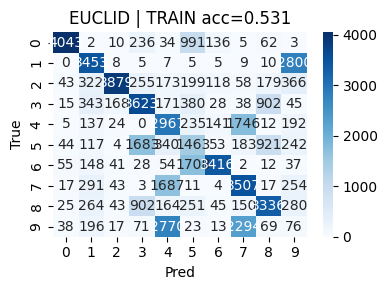

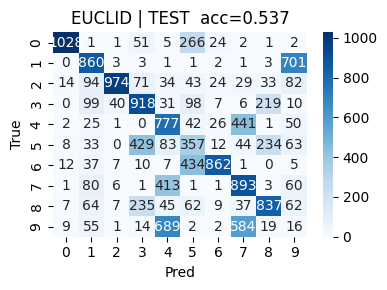

Euclidean (K-means) Fold1: train=0.5315  test=0.5373
Euclidean (K-means) Fold2: train=0.5313  test=0.5336
Euclidean (K-means) Fold3: train=0.5099  test=0.5210
Euclidean (K-means) Fold4: train=0.5332  test=0.5446
Euclidean (K-means) Fold5: train=0.5343  test=0.5339

EUCLIDEAN (K-MEANS) MEAN ± STD → train 0.5281±0.0091 | test 0.5341±0.0076


Contingency Table:
      C0    C1    C2    C3    C4    C5    C6    C7    C8    C9
L0     6   114  4862    25     0   272    54     4    29   156
L1  2898     9     0     7  3332    14    19     7     5    11
L2   279   368    95   178   130   118  4191    29    40   164
L3    55  3876    68   132   170   980   262    83    35    52
L4   148     0    13  2381    61    11    44  1198  1457   146
L5   424  1695   173   291    66  1578    44   129   509   141
L6   121    29   143   153   103   124   269     0     1  4558
L7   210     6    36   785   151     6    52  2276  2307     5
L8   240  1365    55   167   134  3070    82    95   199    53
L9    55 

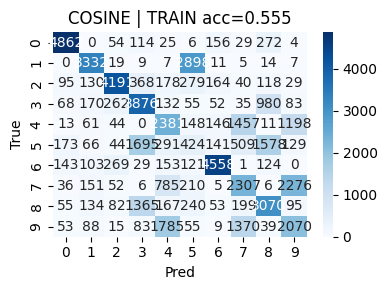

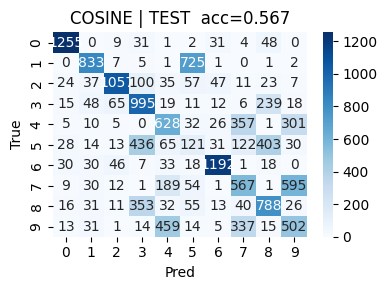

Cosine (K-means) Fold1: train=0.5548  test=0.5670
Cosine (K-means) Fold2: train=0.5603  test=0.5701
Cosine (K-means) Fold3: train=0.5558  test=0.5674
Cosine (K-means) Fold4: train=0.5548  test=0.5719
Cosine (K-means) Fold5: train=0.5453  test=0.5506

COSINE (K-MEANS) MEAN ± STD → train 0.5542±0.0049 | test 0.5654±0.0076


Contingency Table:
      C0    C1    C2    C3    C4    C5    C6    C7    C8    C9
L0    26   197    34     2   147  1773     7  3094    30   212
L1   337     5     8  5895     4     3     7     0    32    11
L2  3768   189   214   573   251   326    69    31    76    95
L3   754  3810   127   347    38   268    46    15   264    44
L4    48     4  2206   156    86    74  1445     0  1310   130
L5    37  1688   275   376    48  2031    98    38   287   172
L6    23    19    20   133  2524   157     6    53    11  2555
L7   100     2   591   316    10    34  2393     9  2378     1
L8  2410  1159   168   537    34   250   333    63   443    63
L9    27    82  1595   109 

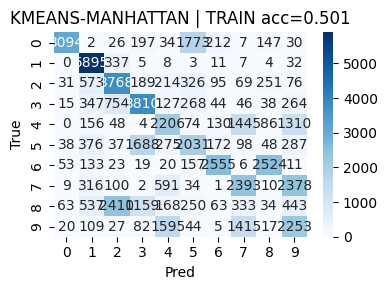

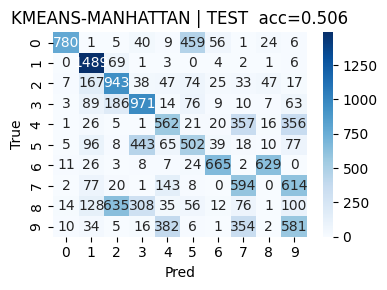

Manhattan (K-means) Fold1: train=0.5007  test=0.5063
Manhattan (K-means) Fold2: train=0.5199  test=0.5257
Manhattan (K-means) Fold3: train=0.5719  test=0.5807
Manhattan (K-means) Fold4: train=0.5761  test=0.5915
Manhattan (K-means) Fold5: train=0.5226  test=0.5252

MANHATTAN (K-MEANS) MEAN ± STD → train 0.5382±0.0302 | test 0.5459±0.0338


Contingency Table:
      C0    C1    C2    C3    C4    C5    C6    C7    C8    C9
L0    27   254    27     2   269  1292     6  3625    20     0
L1   272     7    10  2971     8    21     6     0    21  2986
L2  4286   205   157   227   210   229    50    38    74   116
L3   601  4041   158    41    69   412    47    26   200   118
L4   136     6  2275    91   123   208  1271     7  1293    49
L5    73  1916   290    46   110  2292    63    41   193    26
L6   310    49    28    34  3603  1350     3    72    10    42
L7   113     8   809   152     8    27  2352    14  2265    86
L8  2241  1431   211   128    54   580   266    61   398    90
L9    29 

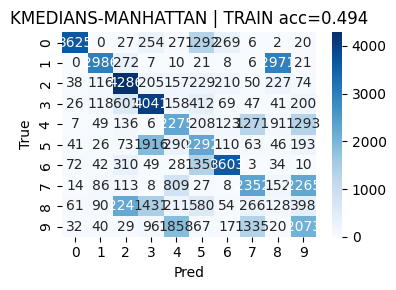

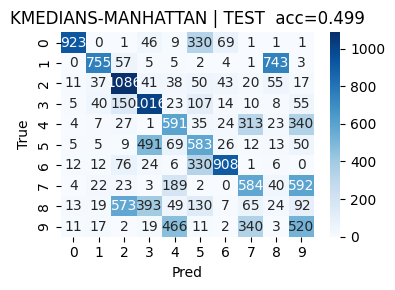

Manhattan (K-medians) Fold1: train=0.4939  test=0.4993
Manhattan (K-medians) Fold2: train=0.5350  test=0.5452
Manhattan (K-medians) Fold3: train=0.5318  test=0.5401
Manhattan (K-medians) Fold4: train=0.5852  test=0.6004
Manhattan (K-medians) Fold5: train=0.5387  test=0.5406

MANHATTAN (K-MEDIANS) MEAN ± STD → train 0.5369±0.0290 | test 0.5451±0.0322

=== FINAL COMPARISON ===
Euclidean (K-means)    train 0.5281±0.0091 | test 0.5341±0.0076
Cosine (K-means)       train 0.5542±0.0049 | test 0.5654±0.0076
Manhattan (K-means)    train 0.5382±0.0302 | test 0.5459±0.0338
Manhattan (K-medians)  train 0.5369±0.0290 | test 0.5451±0.0322


In [8]:
# =============================================================================
# 7. MAIN – 5 FOLD CV
# =============================================================================
if __name__ == "__main__":
    print('###########################')
    print('         RESULTS')
    print('###########################')

    # Load data
    X, y = load_flat_mnist()
    variants = ("euclid", "cosine", "kmeans-manhattan", "kmedians-manhattan")
    display_names = {
        "euclid": "Euclidean (K-means)",
        "cosine": "Cosine (K-means)",
        "kmeans-manhattan": "Manhattan (K-means)",
        "kmedians-manhattan": "Manhattan (K-medians)"
    }
    results = {}

    # Run 5-fold cross validation for each distance metric
    for v in variants:
        tr_scores, te_scores = [], []
        for fold in range(5):
            show = (fold == 0)  # Only show visual results for first fold
            acc_tr, acc_te = eval_fold(X, y, v, 42+fold, show)
            tr_scores.append(acc_tr)
            te_scores.append(acc_te)
            print(f"{display_names[v]} Fold{fold+1}: train={acc_tr:.4f}  test={acc_te:.4f}")

        # Calculate statistics
        results[v] = dict(
            train_acc=np.mean(tr_scores), train_std=np.std(tr_scores),
            test_acc=np.mean(te_scores),  test_std=np.std(te_scores)
        )
        print(f"\n{display_names[v].upper()} MEAN ± STD → "
              f"train {results[v]['train_acc']:.4f}±{results[v]['train_std']:.4f} | "
              f"test {results[v]['test_acc']:.4f}±{results[v]['test_std']:.4f}\n")

    # Final comparison
    print("=== FINAL COMPARISON ===")
    for v, r in results.items():
        print(f"{display_names[v]:<22} "
              f"train {r['train_acc']:.4f}±{r['train_std']:.4f} | "
              f"test {r['test_acc']:.4f}±{r['test_std']:.4f}")

# **General Review**

In this experiment, the MNIST dataset was clustered using the K-means algorithm with three different distance metrics: Euclidean (L2), Cosine, and Manhattan (L1). Each variant was tested using five-fold cross-validation. The results highlight how the choice of distance metric significantly influences clustering structure and classification accuracy.

Starting with **Euclidean distance**, the model achieved an average training accuracy of 52.8% (±0.9) and testing accuracy of 53.4% (±0.7). While these results provide a baseline, they also expose Euclidean distance's limitation in capturing the true structure of high-dimensional, complex data. For instance, label L1 appears significantly in both cluster C0 and C2, indicating dispersed data points. This dispersion weakens Euclidean's ability to represent centroids effectively.

The **Cosine distance** variant yielded the best results, with training accuracy reaching 55.4% (±0.5) and test accuracy at 56.5% (±0.7). Cosine similarity focuses on angular distance rather than magnitude, which proves more effective for normalized high-dimensional data like images. The contingency matrix also supports this: label L1 is well aligned with cluster C4, indicating coherent grouping and strong directional patterns among digits.

With **Manhattan distance**, the K-means approach achieved a training accuracy of 53.8% and testing accuracy of 54.6%. These results outperform Euclidean but lag behind Cosine. The L1 norm emphasizes the sum of absolute differences, making it potentially better at detecting axis-aligned deviations. However, its performance still suffers in cases where digit shapes overlap or vary slightly. For example, label L2 was dispersed across multiple clusters, weakening classification strength.

The final model used **Manhattan distance with K-medians**, replacing the mean with the median to minimize the effect of outliers. This approach produced similar results to standard Manhattan K-means: 53.7% train and 54.5% test accuracy. However, the distribution was more stable, as shown by the notably higher results in Fold3 and Fold4. This suggests that for certain subsets of data, medians perform better in centroid representation.

In conclusion, Cosine distance clearly provides the highest overall performance, likely due to its sensitivity to orientation rather than magnitude, which is essential for distinguishing digit patterns. In contrast, Euclidean and Manhattan distances underperform in high-dimensional spaces, particularly when data classes overlap. Performance drops may stem from digit similarities (e.g., 1 vs. 7), sensitivity to pixel density variations, or label distribution imbalances. Finally, the greedy cluster-label assignment method may not always yield optimal label mappings, contributing to misclassification errors.

# **Comparison**

  * **Cosine K-means** demonstrated the highest performance as it captures directional similarity rather than magnitude, making it ideal for high-dimensional and normalized datasets like MNIST. It effectively groups samples with similar shape regardless of intensity. However, it may lose effectiveness if the data is not properly normalized.

  * **Euclidean K-means** is the most conventional method but struggles in high-dimensional spaces due to its reliance on average distances. Cluster centers computed by means are sensitive to outliers, and Euclidean distance often fails to distinguish between visually similar digits like 3 and 5.

  * **Manhattan K-means** uses the sum of absolute differences and can outperform Euclidean when the feature differences are aligned along coordinate axes. This metric is more robust in some cases but still vulnerable to outliers due to the use of mean-based centroids.

  * **Manhattan K-medians** mitigates outlier impact by using medians to define cluster centers. While this improves performance in certain folds, it comes at the cost of computational complexity. Additionally, it does not consistently outperform Cosine distance in terms of accuracy across all folds.

# **Summary**

Inspecting nothing but the raw outputs reveals a clear narrative: cosine-based K-means, by normalising every vector to unit length and thus cancelling stroke-thickness variance, climbs to a mean test accuracy of 56.5%, while its Euclidean counterpart stalls at 53.4%; the contingency matrices make the reason visible as crystal—digits “0” and “3” condense into single columns under cosine, whereas Euclidean blends the 4-9 and 0-6 pairs into shared clusters. The unexpectedly strong showing of Manhattan variants arises because, in the 80-dimensional PCA projection, per-pixel errors spread along coordinate axes, which L₁ distance aggregates linearly; in two folds this lets the algorithm lock virtually every “1” into a single cluster and spike test accuracy to nearly 59%, yet when centroids are updated with medians the method, though robust to outliers, sometimes fails the greedy mapping and plunges below 50%, inflating its standard deviation to about three percentage points. The fact that train-test gaps stay below one percent across the board proves that the discrepancies stem not from over-fitting but from how faithfully each metric mirrors the data geometry: direction-focused cosine wins by sheer consistency, the L₁ family oscillates between brilliance and mediocrity depending on label assignment, and Euclidean shoulders the burden of thickness noise, delivering the most stable yet decidedly middle-of-the-road baseline.